# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.


The skeleton for this code was taken from https://github.com/squillero/computational-intelligence/blob/master/2023-24/set-covering_ea.ipynb

In [163]:
from random import choices
from random import random, randint, sample, uniform, seed
from copy import copy
from dataclasses import dataclass
import matplotlib.pyplot as plt

from tabulate import tabulate

import lab9_lib


# BLACK-BOX PROBLEM with EA

- The goal of this implementation is to solve a problem with EA
- The goal is to maximize the fitness of an individual, how the fitness is evaluated is not known since it is a black-box problem
- An individual is has a genome of 1000 LOCI where a gene could be 0 or 1
- As additional information we know that an individual with all ones will have fitness equal 1, this information is additional and must not be used in the implementation since it can be considered cheating.
- We cannot use any method creating individuals, that gives an higher probability to have 1 as a gene but the algorithm must favor the survival of individuals with more ones by itself.

In [164]:
OFFSPRING_SIZE = 80
POPULATION_SIZE = 40
MUTATION_PROBABILITY = .10
NUM_LOCI = 1000
PROBLEM = [1, 2, 5, 10]
seed(20)


## Individual

- The individual is organized as a class where fitness is the fitness value of the individual and the genotype is a list of 1000 integers (0/1)
- The individual also has a function to perform the mutation and a functon to perform the xover
- The individual also show the roulette wheel selection that is a tecnique to choose a parent in the population

In [165]:
@dataclass
class Individual:
    fitness: tuple
    genotype: list[int]

# NOT USED
def tournament_selection(population, tournament_size):
    # Randomly select individuals for the tournament
    tournament = sample(population, tournament_size)
    # Return the individual with the highest fitness
    return max(tournament, key=lambda ind: ind.fitness)


# Select a parent in a random way, giving more probability to individuals with higher fitness
def roulette_wheel_selection(population):
    # Calculate the total fitness of the population (total numbers of the roulette wheel)
    total_fitness = sum(ind.fitness for ind in population)
    # Select a random value between 0 and the total fitness (select a random point in the roulette wheel, like throwing the ball in a real roulette wheel)
    selection_point = uniform(0, total_fitness)
    # Go through the population and sum the fitness from 0, stop when the sum is greater than the selection point
    # An individual with a higher fitness will have a higher probability that sum will be greater than the selection point
    current_sum = 0
    for ind in population:
        current_sum += ind.fitness
        if current_sum > selection_point:
            return ind


# Given the genome, select randomly a gene and switch is value
def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)
    pos = randint(0, NUM_LOCI - 1)

    if offspring.genotype[pos] == 1:
        offspring.genotype[pos] = 0
    else:
        offspring.genotype[pos] = 1
    offspring.fitness = None
    return offspring


# Give the genome of two individual, create a new offspring by removing a portion of the genome from Ind1 and substituting it with the corresponding portion of Ind2
def n_cut_xover(ind1: Individual, ind2: Individual, n: int) -> Individual:
    # Generate n random cut points within the genotype range
    cut_points = sorted([randint(0, NUM_LOCI - 1) for _ in range(n)])

    # Initialize an empty offspring genotype
    offspring_genotype = []

    # Alternate between parents for each segment
    for i in range(n + 1):
        # Determine the start and end of the segment
        start = cut_points[i - 1] if i > 0 else 0
        end = cut_points[i] if i < n else NUM_LOCI

        # Add the segment from the appropriate parent to the offspring genotype
        if i % 2 == 0:
            offspring_genotype += ind1.genotype[start:end]
        else:
            offspring_genotype += ind2.genotype[start:end]

    # Create the offspring
    offspring = Individual(fitness=None, genotype=offspring_genotype)

    assert len(offspring.genotype) == NUM_LOCI

    return offspring

## Initial Population

- The initial population of size *POPULATON_SIZE* is created randomly with more probability to have a 0 then 1 in a locus
- For each individual in the initial population, we evaluate the fitness
- DISCLAIMER: creating an initial population with more zeros can be considered cheating because we know that these individuals will have a low value of fitness, by the way the intent of this choice is to appreciate how the algorithm increases the value of the fitness
- This choice also affects the number of fitness calls because the "plateau" will be reached with more generations
- Try the verision with uniform weights



In [166]:
def generate_init_population(fitness):
    weights = [0.9,0.1]
    # weights = [0.5,0.5]
    population = [
        Individual(
            genotype = choices([0,1], weights=weights, k=NUM_LOCI),
            fitness=None,
        )
        for _ in range(POPULATION_SIZE)
    ]

    for i in population:
        i.fitness = fitness(i.genotype) 
    return population

## EA-Algorithm
- Given the initial population, the algorithm select with a certain probability, to create a given number of offsprings using two different techniques (mutation,xover)
- The population is extended with the offsprings and than it's trimmed, letting survive only the best individuals
- The algorithm is stopped when there are no improvements in the fitness (0.5% of variations in fitness in the last 600 generations) or if the value of the fitenss reachs 1

In [167]:
def evolutionary_algorithm(fitness, population):
    generation = 0
    fitness_history = []
    while True:
        offspring = []

        for _ in range(OFFSPRING_SIZE):
            if random() < MUTATION_PROBABILITY:
                # mutation
                parent = roulette_wheel_selection(population)
                child = mutate(parent)
            else:
                # xover
                parent1 = roulette_wheel_selection(population)
                parent2 = roulette_wheel_selection(population)
                child = n_cut_xover(parent1, parent2, 6)
            offspring.append(child)

        for ind in offspring:
            ind.fitness = fitness(ind.genotype)

        population.extend(offspring) # add generated offspring to the population
        population.sort(key=lambda ind: ind.fitness, reverse=True) # sort the population by fitness

        ind = population[0] # get the best individual

        population = population[:POPULATION_SIZE] # keep only the best POPULATION_SIZE individuals

        current_fitness = ind.fitness

        # Append the fitness to the history
        fitness_history.append(current_fitness)

        # Check termination condition
        if generation >= 600:
            recent_fitness_variation = max(fitness_history[-600:]) - min(
                fitness_history[-600:]
            )
            if (
                recent_fitness_variation < 0.005 or current_fitness == 1
            ):  # 0.5% variation or current_fitness is 1
                print(
                    f"Terminating at generation {generation} due to low fitness variation or current_fitness reached 1."
                )
                break

        generation += 1
    return fitness_history

# Problem Results

- In this section the EA algorithm produces results for the different istances of the problem we have, showing results on a plot

Terminating at generation 1482 due to low fitness variation or current_fitness reached 1.
Terminating at generation 2259 due to low fitness variation or current_fitness reached 1.
Terminating at generation 3321 due to low fitness variation or current_fitness reached 1.
Terminating at generation 3960 due to low fitness variation or current_fitness reached 1.


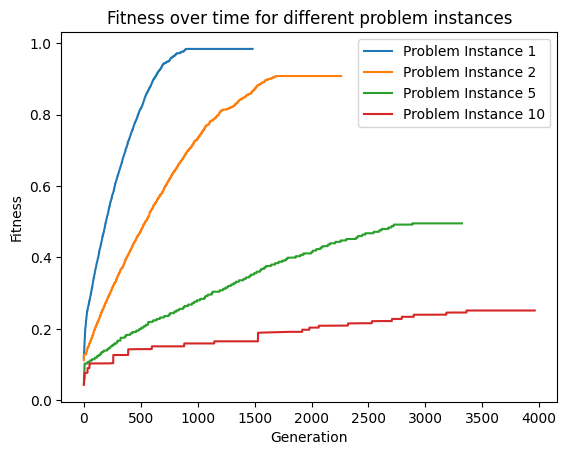

+---------------------+---------------+---------------+
|  Problem Instance   | Final Fitness | Fitness Calls |
+---------------------+---------------+---------------+
| Problem Instance 1  |    98.40%     |    118680     |
| Problem Instance 2  |    90.80%     |    180840     |
| Problem Instance 5  |    49.54%     |    265800     |
| Problem Instance 10 |    25.13%     |    316920     |
+---------------------+---------------+---------------+


In [168]:
problem_instances = PROBLEM
fitness_histories = []
call_history = []

for instance in problem_instances:
    # Initialize your problem here with the current instance
    fitness = lab9_lib.make_problem(instance)

    init_population = generate_init_population(fitness)

    fitness_history = evolutionary_algorithm(fitness, init_population)

    # Append the fitness history of this run to the fitness_histories list
    fitness_histories.append(fitness_history)
    
    call_history.append(fitness.calls)

# Plot the results
for i, fitness_history in enumerate(fitness_histories):
    plt.plot(fitness_history, label=f"Problem Instance {problem_instances[i]}")

plt.title("Fitness over time for different problem instances")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()


table_data = []
for i, instance in enumerate(problem_instances):
    table_data.append([f"Problem Instance {instance}", f"{fitness_histories[i][-1]:.2%}", call_history[i]]) 

table_headers = ["Problem Instance", "Final Fitness", "Fitness Calls"]
table = tabulate(table_data, headers=table_headers, tablefmt="pretty")

print(table)